# Region Proposal Networks with MNIST

Region proposal networks are an important base of all object detection networks.  Here we'll explore one based on the mnist data set, though we'll have to create our own images on the fly from the data set.  It's not ideal in terms of speed, but that isn't the most important part of the tutorial.

## MNIST data set

The MNIST data set is famous, see other blog posts.  Here we will build a custom wrapper to insert 1 to 3 digits into a 64x64 sized image.

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2
import tensorflow as tf
import numpy
from tensorflow.examples.tutorials.mnist import input_data

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


With tensorflow, you can specify which device to use.  The next cell will tell you what's available, and you can select from there.  By default, I select "/gpu:0" but you can change this below

In [2]:
from tensorflow.python.client import device_lib
print device_lib.list_local_devices()
default_device = "/cpu:0"

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8740546744093419741
]


Here is the helper class for embedding.  Note how it keeps track of the regions of each digit and their labels, as well.

In [3]:
class mnist_helper(object):
    """
    Repackage several mnist digits into a larger image, and also keep track of their regions
    """
    def __init__(self):
        super(mnist_helper, self).__init__()
        self.mnist = input_data.read_data_sets('MNIST_data', one_hot=False)

    def next_multi_image_train_classification(self, batch_size=4, max_images=4):
        '''
        Build a multi digit image with up to 3 images randomly placed in a 64x64 grid:
        
        This function doesn't find image regions
        '''
        output = numpy.zeros((batch_size, 64, 64))
        return_labels = numpy.zeros((batch_size, 10))
        
        for i in xrange(batch_size):
            n_images = numpy.random.randint(max_images-1) + 1
            batch, labels = self.mnist.train.next_batch(n_images)
            for image, label in zip(batch, labels):
                x_rand = numpy.random.randint(34)
                y_rand = numpy.random.randint(34)
                output[i,x_rand:x_rand+28, y_rand:y_rand+28] += image.reshape((28,28))
                return_labels[i,label] = 1
        return output, return_labels
            
    
    
    def next_multi_image_train(self, batch_size=4, return_labels=True, return_rois=False):
        # Build mnist images, each embedded into a 64x64 space
        # instead of 28x28
        batch, labels = self.mnist.train.next_batch(batch_size)
        # build an output data container:
        output = numpy.zeros((batch_size, 64, 64))
        return_labels = numpy.zeros((batch_size,10))
        # Copy images to output:
        n_images = numpy.random.randint(3)
        for i in xrange(batch_size):
            for j in xrange(n_images):
                x_start = numpy.random.randint(32)
                y_start = numpy.random.randint(32)
                output[i,x_start:x_start+28, y_start:y_start+28] += batch[image].reshape((28,28))
                labels[i][labels[i]] = 1
        if return_labels:
            return numpy.reshape(output, [batch_size, 32, 32, 1]), labels
        else:            
            return numpy.reshape(output, [batch_size, 32, 32, 1])
        
        


In [4]:
data_fetcher = mnist_helper()
mnist_images, mnist_labels = data_fetcher.next_multi_image_train_classification(batch_size=5)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Here, we've loaded the mnist data from the tensorflow helper class, and asked for the next batch of images and labels.  Let's view those to see what the data looks like before delving into the network:

In [5]:
print "mnist_images.shape: {}".format(mnist_images.shape)
print "mnist_labels.shape: {}".format(mnist_labels.shape)

mnist_images.shape: (5, 64, 64)
mnist_labels.shape: (5, 10)


As expected, variables are arrays with the outermost dimension equal to 5.  The images, though, comes unpacked as a 1D array per image instead of a 2D array.  We can reshape this to what we're more familar with, since we know mnist images are 28x28:

In [6]:
print "mnist_images.shape: {}".format(mnist_images.shape)


mnist_images.shape: (5, 64, 64)


Matplotlib gives a good interface for viewing these images in a notebook (or even in general, in python):

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

This image is labeled as [ 0.  0.  0.  0.  1.  0.  0.  0.  1.  0.]


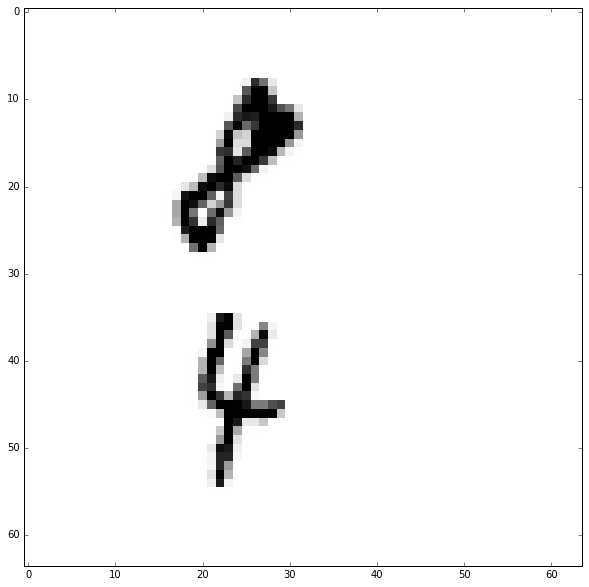

This image is labeled as [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


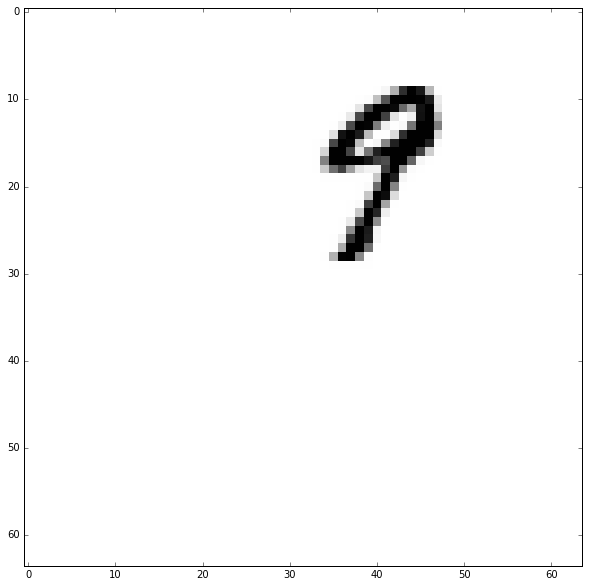

This image is labeled as [ 1.  0.  1.  1.  0.  0.  0.  0.  0.  0.]


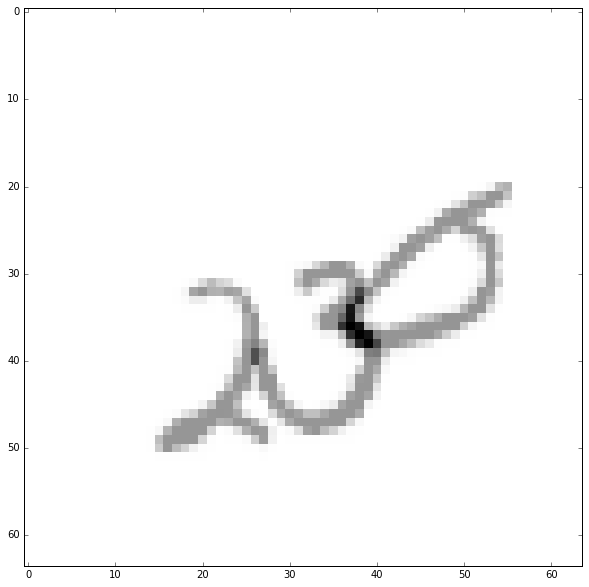

This image is labeled as [ 1.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


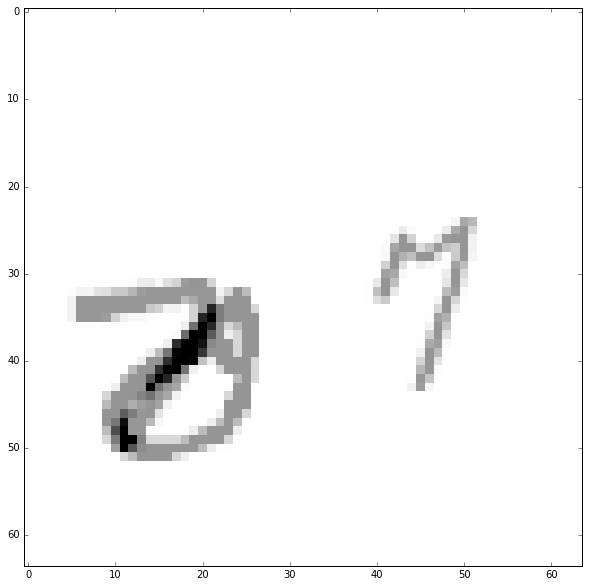

This image is labeled as [ 0.  0.  0.  0.  0.  1.  0.  1.  0.  0.]


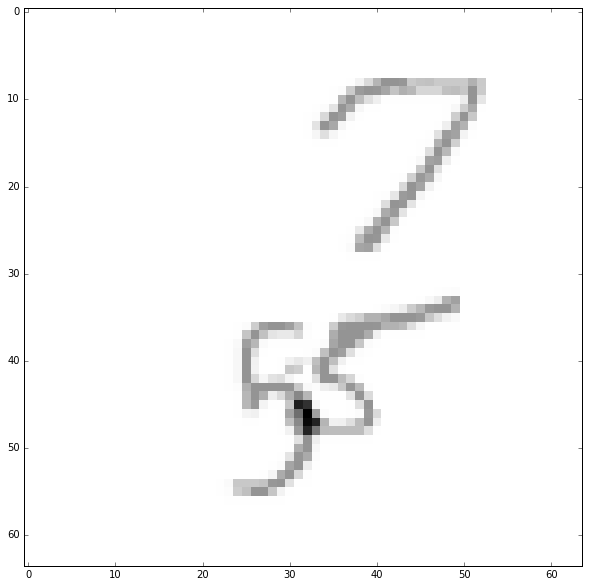

In [8]:
for index in xrange(5):
    fig = plt.figure(figsize=(10,10))
    plt.imshow(mnist_images[index,:,:], cmap="Greys", interpolation="none")
    print "This image is labeled as {}".format(mnist_labels[index])
    plt.show()

These show numbers distributed around the image, so that's good.

### Building a classification network

We'll start to put together a network classification of images, which is a useful way to pretrain the RPN

In [9]:
BASE_LEARNING_RATE = 0.00001
BATCH_SIZE=36
RESTORE=False
LOGDIR="./rpn_mnist_classification/"
TRAINING=True

Additionally, let's make sure we have the same graph by defining it:

In [10]:
tf.reset_default_graph()
g = tf.Graph()

Set up the placeholders for the input variables.  We'll need to input both images and labels

In [11]:
with tf.device(default_device):
    with g.as_default():

        # Placeholder for the real input images:
        images_input  = tf.placeholder(tf.float32, (None, 64, 64,), name="real_images_input")
        # Placeholder for the real labels:
        labels  = tf.placeholder(tf.float32, [None, 10], name="real_labels")
       
        images = tf.reshape(images_input, [-1, 64, 64, 1])


Now we can define the networks.  In this case, there are 3: a transformer, a discriminator, and a classifier.  We will do the transformer first.

### Image Classifier:

We will build a simple classifier to decide what digits are present in the image, using a residual network.  Here are some useful functions to build the network up:

In [12]:
def residual_block(input_tensor,
                   is_training,
                   kernel=[3, 3],
                   stride=[1, 1],
                   name="",
                   reuse=False):
    """
    @brief      Create a residual block and apply it to the input tensor

    @param      input_tensor  The input tensor
    @param      kernel        Size of convolutional kernel to apply
    @param      n_filters     Number of output filters

    @return     { Tensor with the residual network applied }
    """

    # Residual block has the identity path summed with the output of
    # BN/Relu/Conv2d applied twice

    # Assuming channels last here:
    n_filters = input_tensor.shape[-1]

    with tf.variable_scope(name + "_0"):
        # Batch normalization is applied first:
        x = tf.layers.batch_normalization(input_tensor,
                                          axis=-1,
                                          training=is_training,
                                          trainable=True,
                                          name="BatchNorm",
                                          reuse=reuse)


        # Conv2d:
        x = tf.layers.conv2d(x, n_filters,
                             kernel_size=kernel,
                             strides=stride,
                             padding='same',
                             trainable=is_training,
                             name="Conv2D",
                             reuse=reuse)
        # ReLU:
        x = tf.nn.relu(x)
        
    # Apply everything a second time:
    with tf.variable_scope(name + "_1"):

        # Batch normalization is applied first:
        x = tf.layers.batch_normalization(x,
                                          axis=-1,
                                          training=is_training,
                                          trainable=True,
                                          name="BatchNorm",
                                          reuse=reuse)

        # Conv2d:
        x = tf.layers.conv2d(x,
                             n_filters,
                             kernel_size=kernel,
                             strides=stride,
                             padding='same',
                             trainable=is_training,
                             name="Conv2D",
                             reuse=reuse)

    # Sum the input and the output:
    with tf.variable_scope(name+"_addition"):
        x = tf.add(x, input_tensor, name="Add")
        x = tf.nn.relu(x)
    return x



In [13]:
def downsample_block(input_tensor,
                     is_training,
                     kernel=[3, 3],
                     name="",
                     increase_filters=True,
                     reuse = False):
    """
    @brief      Create a residual block and apply it to the input tensor

    @param      input_tensor  The input tensor
    @param      kernel        Size of convolutional kernel to apply
    @param      n_filters     Number of output filters

    @return     { Tensor with the residual network applied }
    """

    # Residual block has the identity path summed with the output of
    # BN/Relu/Conv2d applied twice

    # Assuming channels last here:
    if not increase_filters:
        n_filters = input_tensor.get_shape().as_list()[-1]
    else:
        n_filters = 2*input_tensor.get_shape().as_list()[-1]

    with tf.variable_scope(name + "_0"):
        # Batch normalization is applied first:
        x = tf.layers.batch_normalization(input_tensor,
                                          training=is_training,
                                          trainable=True,
                                          name="BatchNorm",
                                          reuse=reuse)


        # Conv2d:
        x = tf.layers.conv2d(x, n_filters,
                             kernel_size=kernel,
                             strides=[2, 2],
                             padding='same',
                             trainable=is_training,
                             name="Conv2D",
                             reuse=reuse)

        # ReLU:
        x = tf.nn.relu(x)

    return x

In [14]:
# def upsample_block(input_tensor,
#                    is_training,
#                    kernel=[3, 3],
#                    alpha = 0.0,
#                    name=""):
#     """
#     @brief      Create a residual block and apply it to the input tensor

#     @param      input_tensor  The input tensor
#     @param      kernel        Size of convolutional kernel to apply
#     @param      n_filters     Number of output filters

#     @return     { Tensor with the residual network applied }
#     """

#     # Residual block has the identity path summed with the output of
#     # BN/Relu/Conv2d applied twice

#     # Assuming channels last here:
#     n_filters = int(0.5*input_tensor.get_shape().as_list()[-1])
#     # Prevent attempts to produce no filters at the next stage up:
#     if n_filters == 0:
#         n_filters = 1

#     with tf.variable_scope(name + "_0"):
#         # Batch normalization is applied first:
#         x = tf.layers.batch_normalization(input_tensor,
#                                           training=is_training,
#                                           trainable=True,
#                                           name="BatchNorm",
#                                           reuse=None)

#         # Conv2d:
#         x = tf.layers.conv2d_transpose(x, n_filters,
#                              kernel_size=kernel,
#                              strides=[2, 2],
#                              padding='same',
#                              trainable=True,
#                              name="Conv2DTrans",
#                              reuse=None)
#         # ReLU:
#         x = tf.nn.relu(x)

#     return x

In [15]:
def build_classifier(input_tensor, n_initial_filters=32, is_training=True):
    # Again, scoping is essential here:
    with tf.variable_scope("mnist_classifier"):
       

        # To make this code cleaner, the upsampling, downsampling, and residual block steps have all be 
        # written as functions above.
        
        # Map the input tensor with an intial convolution:
        x = tf.layers.batch_normalization(input_tensor,
                                          training=is_training,
                                          trainable=True,
                                          name="BatchNormInitial",
                                          reuse=None)
        
        x = tf.layers.conv2d(x, n_initial_filters, 
                            kernel_size=[5,5],
                            strides=[1,1],
                            padding="same",
                            trainable=True,
                            name="InitialConv2D")
        
        # Apply a series of downsampling blocks to take the spatial dimensions down as follows:
        # (B, 32, 32, n_initial_filters)
        # (B, 16, 16, 2*n_initial_filters)
        # (B, 8, 8, 4*n_initial_filters)
        # (B, 4, 4, 8*n_initial_filters)
        # After each residual block, store the output to connect to the upsampling block
        
        for i in [32, 16, 8, 4]:
            x = residual_block(x,
                               is_training,
                               name="residual_block_down_{}".format(i))
            # Downsample:
            x = downsample_block(x, is_training,
                                name="downsample_block_{}".format(i))

            
        # Now at the bottom of the network, apply a residual block:
        x = residual_block(x, is_training,
                           name="residual_block_bottom")
            
        # Finally, we apply a bottleneck to map the tensors to a (B, 10) shaped output:
        x = tf.layers.conv2d(x, 10,
                             kernel_size=[1,1],
                             strides=[1,1],
                             name ="FinalBottleneck")
        
        # Global average pooling and reshape to final output size:
        # For global average pooling, need to get the shape of the input:
        shape = (x.shape[1], x.shape[2])

        x = tf.nn.pool(x,
                       window_shape=shape,
                       pooling_type="AVG",
                       padding="VALID",
                       name="GlobalAveragePool")

        # Reshape to remove empty dimensions:
        x = tf.reshape(x, [tf.shape(x)[0], 10],
                       name="global_pooling_reshape")

        # Final activation is sigmoid
        # x = tf.nn.sigmoid(x)
        # We don't apply it here, instead it's done in the sigmoid_cross_entropy_# For global average pooling, need to get the shape of the input:
        return x

In [16]:
with tf.device(default_device):
    with g.as_default():
        logits = build_classifier(images, is_training=TRAINING)


### Classification Loss functions

We can now define our loss functions.  Note that we have to define the loss function for the real and transformed data seperately:

In [17]:
with tf.device(default_device):
    # Build the loss functions:
    with g.as_default():
        with tf.name_scope("cross_entropy") as scope:

            #########################################################################
            # Build the loss functions for the discriminator first:
            #########################################################################
            
            # Discriminator loss on real images (classify as 1):
            class_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,
                                                        labels = labels))
                
            
            # This code is useful if you'll use tensorboard to monitor training:
            tf.summary.scalar("Classifier_Loss", class_loss)
            

It's also useful to compute accuracy, just to see how the training is going:

In [18]:
with tf.device(default_device):
    with g.as_default():
        with tf.name_scope("accuracy") as scope:
            # Compute the discriminator accuracy on real data, fake data, and total:
            accuracy   = tf.reduce_mean(tf.cast(tf.equal(tf.round(logits), labels), tf.float32))

            # Again, useful for tensorboard:
            tf.summary.scalar("Label_Accuracy", accuracy)


### Optimizers

A simple optimizer will work for the classification task

In [19]:
with tf.device(default_device):
    with g.as_default():
        with tf.name_scope("training") as scope:
            # Global steps are useful for restoring training:
            global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')

            optimizer   = tf.train.AdamOptimizer(BASE_LEARNING_RATE, 0.5).minimize(
                class_loss, global_step=global_step)

## Training the networks

There are lots of philosophys on training GANs.  Here, we'll do something simple and just alternate updates. To save the network and keep track of training variables, set up a summary writer:

In [ ]:
with tf.device(default_device):
    with g.as_default():
        merged_summary = tf.summary.merge_all()

        # Set up a saver:
        train_writer = tf.summary.FileWriter(LOGDIR)

Set up a session for training using an interactive session:

In [ ]:
if TRAINING:
    with tf.device(default_device):
        with g.as_default():
            sess = tf.InteractiveSession()
            if not RESTORE:
                sess.run(tf.global_variables_initializer())
                train_writer.add_graph(sess.graph)
                saver = tf.train.Saver()
            else: 
                latest_checkpoint = tf.train.latest_checkpoint(LOGDIR+"/checkpoints/")
                print "Restoring model from {}".format(latest_checkpoint)
                saver = tf.train.Saver()
                saver.restore(sess, latest_checkpoint)


            data_fetcher = mnist_helper()

            print "Begin training ..."
            # Run training loop
            for i in xrange(50000):
                step = sess.run(global_step)

                # Get a set of real images and labels to transform:
                comb_images, comb_labels = data_fetcher.next_multi_image_train_classification(int(BATCH_SIZE*0.5))

                # We have to update the discriminator, classifier, and generator.

                
                fd = {images_input : comb_images,
                      labels       : comb_labels}
                
                _, summary = sess.run([optimizer, merged_summary],feed_dict = fd)

                train_writer.add_summary(summary, step)


                if step != 0 and step % 500 == 0:
                    saver.save(
                        sess,
                        LOGDIR+"/checkpoints/save",
                        global_step=step)


                # train_writer.add_summary(summary, i)
                # sys.stdout.write('Training in progress @ step %d\n' % (step))
                if i % 150 == 0:
                    print 'Training in progress @ global_step %d,' % (step)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Begin training ...
Training in progress @ global_step 0,


Let's take a look at some of the output of the network to see the results:

In [ ]:
if not TRAINING:
    with tf.device(default_device):
        with g.as_default():
            sess = tf.InteractiveSession()
            latest_checkpoint = tf.train.latest_checkpoint(LOGDIR+"/checkpoints/")
            print "Restoring model from {}".format(latest_checkpoint)
            saver = tf.train.Saver()
            saver.restore(sess, latest_checkpoint)

            data_fetcher = mnist_helper()

            # For this, we want to be able to compare original to transformed images.  
            pre_transformed_images, pre_transformed_labels = data_fetcher.next_multi_image_train(int(BATCH_SIZE*0.5))


            # No need to add noise to the images, so pass in zeros for noise.
            real_noise_addition = numpy.zeros(shape=(int(BATCH_SIZE*0.5),32,32,1))
            trans_noise_addition = numpy.zeros(shape=(int(BATCH_SIZE*0.5),32,32,1))


            fd = {real_images_input : pre_transformed_images,
                  real_labels       : pre_transformed_labels,
                  pre_trans_images  : pre_transformed_images,
                  real_noise        : real_noise_addition,
                  trans_noise       : trans_noise_addition}


            [generated_images, real_class, trans_class] = sess.run(
                    [transformed_images, 
                     real_image_classification, 
                     trans_image_classification], 
                    feed_dict = fd)


Let's take a look at these images.  We will draw the original on the left and the transformed image on the right, as well as the labels for both 

In [ ]:
for i in xrange(len(generated_images)):
    original = pre_transformed_images[i].reshape((32,32))
    new_img = generated_images[i].reshape((32,32))
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 10))
    ax1.imshow(original, cmap="Greys", interpolation="none")
    ax2.imshow(new_img, cmap="Greys", interpolation="none")
    plt.show()
    
    real_label = numpy.argmax(pre_transformed_labels[i])
    real_prob = real_class[i][real_label]
    selected_label = numpy.argmax(real_class[i])
    print "Original label is {}, selected label is {}, classification probability as {} is {}.".format(
        real_label, selected_label, real_label, real_prob )
    
    break
